In [33]:
import os

import imageio.v2 as imageio
import numpy as np
from typing import List, Tuple

BASE_PATH = "../tests/resources/InputImages/"
# BASE_PATH = ""


In [34]:
def structure_output(
    query: Tuple[str, np.ndarray], results: List[Tuple[str, np.ndarray]]
):
    output = f"Query: {query[0]}\n"
    output += "Ranking:\n"
    for i, result in enumerate(results):
        output += f"({i}) {result[0]} | Similarity: {result[1]}\n"
    print(output[:-1])


In [35]:
def load_images(image_names: List[str]):
    images = [
        imageio.imread(os.path.join(BASE_PATH, image_name))
        for image_name in image_names
    ]
    images = list(map(lambda img: img.astype(np.float32), images))
    return images


In [36]:
# def convert_gray_luminance(images: List[np.ndarray]):
#     lgrays = list(
#         map(
#             lambda image: image.astype(np.uint8),
#             map(
#                 lambda image: image[:, :, 0].astype(float) * 0.299
#                 + image[:, :, 1].astype(float) * 0.587
#                 + image[:, :, 2].astype(float) * 0.114,
#                 images,
#             ),
#         )
#     )
#     return lgrays


def convert_gray_luminance(images):
    lgrays = []
    for image in images:
        rows, cols, _ = image.shape
        lgray = np.zeros((rows, cols))
        lgray[:, :] = image[:, :, 0] * 0.299 + image[:, :, 1] * 0.587 + image[:, :, 2] * 0.114
        lgrays.append(lgray.astype(np.uint8))
    return lgrays


In [37]:
def binarize_images(images, T):
    bin_imgs = []
    for image in images:
        bin_img = np.copy(image)
        bin_img[image < T] = 0
        bin_img[image >= T] = 1
        bin_imgs.append(bin_img)
    return bin_imgs


In [38]:
def erode_image(image):
    eroded = np.zeros_like(image)
    rows, cols = image.shape
    for i in range(1, rows):
        for j in range(1, cols):
            min_val = np.min(image[i - 1 : i + 2, j - 1 : j + 2])
            eroded[i, j] = min_val
    return eroded


In [39]:
def dilate_image(image):
    dilated = np.zeros_like(image)
    rows, cols = image.shape
    for i in range(1, rows):
        for j in range(1, cols):
            max_val = np.max(image[i - 1 : i + 2, j - 1 : j + 2])
            dilated[i, j] = max_val
    return dilated


In [40]:
def erode_images(images):
    eroded = list(map(erode_image, images))
    return eroded


def dilate_images(images):
    dilated = list(map(dilate_image, images))
    return dilated


def closing(images):
    dilated = dilate_images(images)
    closed = erode_images(dilated)
    return closed


def opening(images):
    eroded = erode_images(images)
    opened = dilate_images(eroded)
    return opened


In [41]:
def masks_from(gray_images, morphed_images):
    masks = []
    for gray, morphed in zip(gray_images, morphed_images):
        mask1 = np.zeros_like(gray)
        mask2 = np.zeros_like(gray)
        mask1[morphed == 0] = gray[morphed == 0]
        mask2[morphed == 1] = gray[morphed == 1]
        masks.append((mask1, mask2))
    return masks


In [42]:
def cooccurrence_prob_matrix(mask, Q):
    row, col = mask.shape
    cooc_side = np.max(mask) + 1
    cooc = np.zeros((cooc_side, cooc_side))
    for x in range(1, row - 1):
        for y in range(1, col - 1):
            ref = mask[x, y]
            neigh = mask[x + Q[0], y + Q[1]]
            cooc[ref, neigh] += 1
    prob_matrix = cooc / np.sum(cooc)
    return prob_matrix


def cooccurrence_prob_matrixes(masks, Q):
    matrixes = []
    for mm in masks:
        coocs = [cooccurrence_prob_matrix(m, Q) for m in mm]
        matrixes.append(coocs)
    return matrixes


In [43]:
def vectors_for(prob_matrix: np.ndarray):
    M, N = prob_matrix.shape
    I, J = np.ogrid[0:M, 0:N]
    return I, J


def auto_correlation(prob_matrix: np.ndarray):
    I, J = vectors_for(prob_matrix)
    return (prob_matrix * (I * J)).sum()


def contrast(prob_matrix: np.ndarray):
    I, J = vectors_for(prob_matrix)
    return (np.square(I - J) * prob_matrix).sum()


def dissimilarity(prob_matrix: np.ndarray):
    I, J = vectors_for(prob_matrix)
    return (np.abs(I - J) * prob_matrix).sum()


def energy(prob_matrix: np.ndarray):
    return np.square(prob_matrix).sum()


def entropy(prob_matrix: np.ndarray):
    I, J = vectors_for(prob_matrix)
    return -(prob_matrix[prob_matrix > 0] * np.log(prob_matrix[prob_matrix > 0])).sum()


def homogeneity(prob_matrix: np.ndarray):
    I, J = vectors_for(prob_matrix)
    return (prob_matrix / (1 + np.square(I - J))).sum()


def inverse_difference(prob_matrix: np.ndarray):
    I, J = vectors_for(prob_matrix)
    return (prob_matrix / (1 + np.abs(I - J))).sum()


def maximum_probability(prob_matrix: np.ndarray):
    return np.max(prob_matrix)


def compute_haralick_descriptors(prob_matrixes: List[Tuple[np.ndarray, np.ndarray]]):
    descriptors = []
    for prob_matrix in prob_matrixes:
        auto_corr = [auto_correlation(prob_matrix) for prob_matrix in prob_matrix]
        contr = [contrast(prob_matrix) for prob_matrix in prob_matrix]
        diss = [dissimilarity(prob_matrix) for prob_matrix in prob_matrix]
        en = [energy(prob_matrix) for prob_matrix in prob_matrix]
        entr = [entropy(prob_matrix) for prob_matrix in prob_matrix]
        hom = [homogeneity(prob_matrix) for prob_matrix in prob_matrix]
        inv_diff = [inverse_difference(prob_matrix) for prob_matrix in prob_matrix]
        max_prob = [maximum_probability(prob_matrix) for prob_matrix in prob_matrix]

        # Transposing the tuples to have descriptors per probability matrix
        mask1_desc, mask2_desk = list(
            zip(*[auto_corr, contr, diss, en, entr, hom, inv_diff, max_prob])
        )
        all_descs = np.concatenate((mask1_desc, mask2_desk), axis=None)
        descriptors.append(all_descs)
    return descriptors


In [44]:
def calc_distance(query: np.ndarray, reference: np.ndarray):
    return np.linalg.norm(query - reference)

def order_by_similarity(
    query: Tuple[str, np.ndarray],
    descriptors: List[Tuple[str, np.ndarray]],
):
    distances = [
        (ref_name, calc_distance(query[1], ref_desc))
        for ref_name, ref_desc in descriptors
    ]
    maxdist = max([d[1] for d in distances])
    distances = [(name, (maxdist - dist)/maxdist) for name, dist in distances]
    similarities = [(name, dist) for name, dist in distances]
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    return similarities


In [45]:
query_index = 1
Q = (0, 1)
F = 1
T = 136
B = 6
image_names = [
    "pedras1.png",
    "pedras2.png",
    "grama1.png",
    "grama2.png",
    "parede1.png",
    "parede2.png",
]

images = load_images(image_names)
gray_images = convert_gray_luminance(images)
bin_images = binarize_images(gray_images, T)
morphed_images = list()
if F == 1:
    morphed_images = opening(bin_images)
elif F == 2:
    morphed_images = closing(bin_images)

masks = masks_from(gray_images, morphed_images)


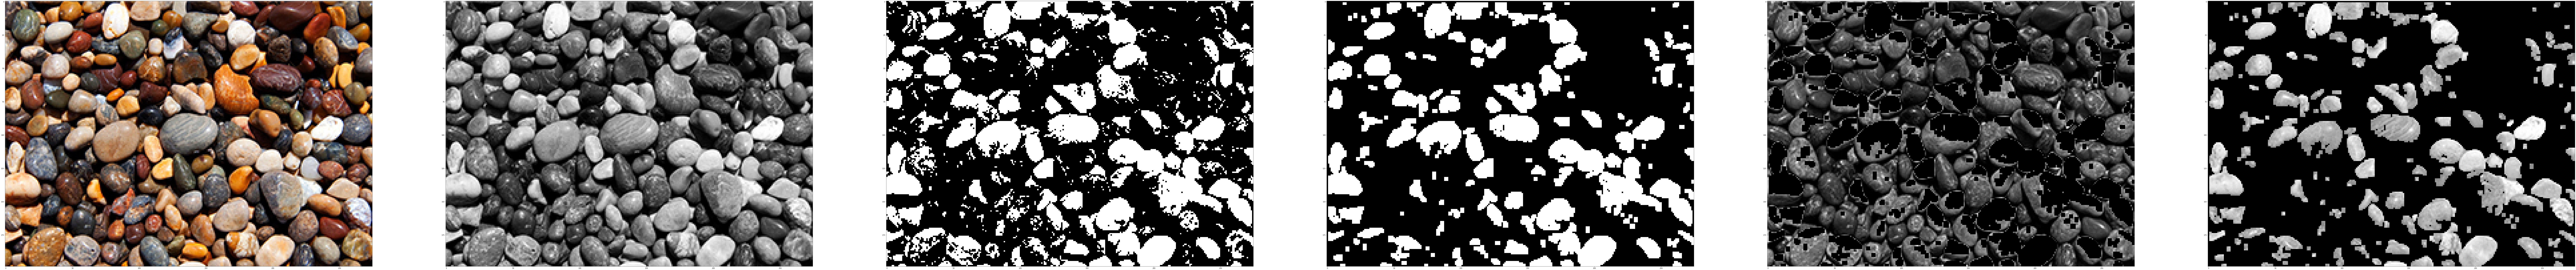

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(300, 400))
plt.subplot(161)
plt.imshow(images[0].astype(np.uint8), vmin=0, vmax=255)
plt.subplot(162)
plt.imshow(gray_images[0], cmap="gray")
plt.subplot(163)
plt.imshow(bin_images[0], cmap="gray")
plt.subplot(164)
plt.imshow(morphed_images[0], cmap="gray")
plt.subplot(165)
plt.imshow(masks[0][0], cmap="gray")
plt.subplot(166)
plt.imshow(masks[0][1], cmap="gray")

In [47]:
# part 2
prob_matrixes = cooccurrence_prob_matrixes(masks, Q)

all_descriptors = compute_haralick_descriptors(prob_matrixes)

descriptors_per_images = list(zip(image_names, all_descriptors))
query_image = (image_names[query_index], all_descriptors[query_index])

results = order_by_similarity(query_image, descriptors_per_images)

structure_output(query_image, results)


Query: pedras2.png
Ranking:
(0) pedras2.png | Similarity: 1.0
(1) pedras1.png | Similarity: 0.8282543742505156
(2) parede2.png | Similarity: 0.203953970608733
(3) parede1.png | Similarity: 0.02743838675179585
(4) grama1.png | Similarity: 0.004376626135960447
(5) grama2.png | Similarity: 0.0


In [48]:
maxval = max([r[1] for r in results])
[(maxval - r[1])/maxval for r in results]

[0.0,
 0.17174562574948438,
 0.796046029391267,
 0.9725616132482041,
 0.9956233738640395,
 1.0]